In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

import MicroTools as micro
import MicroTools.plot_tools as pt

import param_scan
from tqdm.notebook import tqdm

In [26]:
##
RUN_SCANS = True
##

In [28]:
if RUN_SCANS:
    # --------------------------------------------------------------------------------
    #                 Setting up Parameter Scan -- 3-dimensions
    # --------------------------------------------------------------------------------
    path_results = "fit_data/"
    Npoints = 3

    # Range of mixings scanned 
    sin2theta4e_Vec = np.geomspace(1e-4, 0.03, Npoints)
    dm_Vec = np.geomspace(np.sqrt(1e-1), np.sqrt(100), Npoints)

    # Cartesian product of grid
    paramlist = param_scan.create_grid_of_params(g=1, m4=dm_Vec, Ue4Sq=sin2theta4e_Vec/4, Um4Sq=1)

    # Pure oscillation method
    func_scan = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=True, decay=False, decouple_decay=True, disappearance=False, energy_degradation=False)

    # Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
    with Pool() as pool:
        res = list(tqdm(pool.imap(func_scan, paramlist), total=len(paramlist)))

    np.save(f"{path_results}/MH_osc_app_only_test", res)

  0%|          | 0/9 [00:00<?, ?it/s]

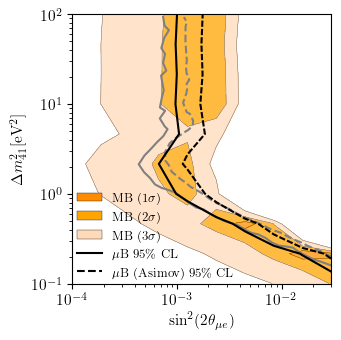

In [6]:
# MicroBooNE chi2 with n, noffset=0, aka oscillation only, decoupled decay, but with Pmm and Pee.
data = np.load(f"fit_data/MH_osc_app_only_test.npy", allow_pickle=True)

sin2theta, dm4SQR = 4*data[:,2]*data[:,3], data[:,1]**2
MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 

MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)

kwargs_interp = {'fine_gridx': len(np.unique(sin2theta)),  
                        'fine_gridy': len(np.unique(dm4SQR)), 
                        'logx':True, 
                        'logy':True,
                        }

levsMicroB = [11.83]
X, Y, Z = pt.interp_grid(sin2theta, dm4SQR, MiniApp_deltachi2, **kwargs_interp)
cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(sin2theta, dm4SQR, MicroApp_deltachi2, **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(sin2theta, dm4SQR, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

# Official MiniBooNE contours 
# cont = np.genfromtxt('MiniTools/include/MB_data_release_2020/fhcmode/cont_fake_oct19_contNu_1s.txt').T
# ax1.scatter(cont[0], cont[1], color='grey', alpha=1, linewidth=0, s=5, label='Official MB $1\sigma$ (app only)')
# cont = np.genfromtxt('MiniTools/include/MB_data_release_2020/fhcmode/cont_fake_oct19_contNu_3s.txt').T
# ax1.scatter(cont[0], cont[1], color='grey', alpha=1, linewidth=0, s=5)
# cont = pt.get_ordered_closed_region(cont, logx=True, logy=False)
# ax1.fill(cont[0], cont[1], edgecolor='grey', facecolor='None', alpha=1, linewidth=0.5)

# Official MicroBooNE 95% CL contours 
cont = np.genfromtxt('MicroTools/muB_data/official/app_only_2022_official.dat').T
ax1.plot(cont[0], cont[1], color='grey', alpha=1, linewidth=1.5, zorder=1)
cont = np.genfromtxt('MicroTools/muB_data/official/app_only_2022_official_sensitivity.dat').T
ax1.plot(cont[0], cont[1], color='grey', alpha=1, linewidth=1.5, linestyle='--', zorder=1)

# Arguelles et al 3 sigma
# uB_osc = np.loadtxt(f'MicroTools/muB_data/osc_only.dat').T
# ax1.plot(uB_osc[0], uB_osc[1], color='dodgerblue', linewidth=3, label='Arguelles et al $\mu$B 3$\sigma$')

ax1.legend(loc=(0,0), fontsize=9)
# fig.savefig(f"{micro.path_plots}/MH_osc_app_only.pdf", bbox_inches='tight', dpi=300)

# Full 3+1 OscillationS (w/ disappearance)

In [7]:
def profile_in_plane(x, y, chi2):
    
    # Create a list of tuples for the unique pairs of Ue4SQR and Umu4SQR
    unique_pairs = np.array(list(set(zip(x, y))))

    # Find the minimum chi2 for each unique pair of Ue4SQR and Umu4SQR
    profiled_chi2 = np.array([np.min(chi2[(x == pair[0]) & (y == pair[1])]) for pair in unique_pairs])

    return unique_pairs[:,0], unique_pairs[:,1], profiled_chi2

In [8]:
if RUN_SCANS:
    # --------------------------------------------------------------------------------
    #                 Setting up Parameter Scan -- 3-dimensions
    # --------------------------------------------------------------------------------
    path_results = "fit_data/"
    Npoints = 10

    # Range of mixings scanned 
    Ue4Sq = np.geomspace(1e-3, 0.5, Npoints)
    Umu4Sq = np.geomspace(1e-3, 0.5, Npoints)
    dm_Vec = np.geomspace(np.sqrt(1e-1), np.sqrt(100), Npoints)


    # Cartesian product of grid
    paramlist = param_scan.create_grid_of_params(g=0, m4=dm_Vec, Ue4Sq=Ue4Sq, Um4Sq=Umu4Sq)

    # Pure oscillation method
    func_scan = partial(param_scan.DecayReturnMicroBooNEChi2, 
                        oscillations=True, 
                        decay=False, 
                        decouple_decay=True, 
                        disappearance=True, 
                        energy_degradation=False, 
                        use_numu_MC=True,
                        n_replications=1)

    with Pool() as pool:
        # res = pool.map(func_scan, paramlist)
        res = list(tqdm(pool.imap(func_scan, paramlist), total=len(paramlist)))

    np.save(f"{path_results}/MH_osc_full_using2009dis", res)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [50]:
if RUN_SCANS:
    # --------------------------------------------------------------------------------
    #                 Setting up Parameter Scan -- 3-dimensions
    # --------------------------------------------------------------------------------
    path_results = "fit_data/"
    Npoints = 10

    # Range of mixings scanned 
    Ue4Sq = np.geomspace(1e-3, 0.5, Npoints)
    Umu4Sq = np.geomspace(1e-3, 0.5, Npoints)
    dm_Vec = np.geomspace(np.sqrt(1e-1), np.sqrt(100), Npoints)


    # Cartesian product of grid
    paramlist = param_scan.create_grid_of_params(g=0, m4=dm_Vec, Ue4Sq=Ue4Sq, Um4Sq=Umu4Sq)

    # Pure oscillation method
    func_scan = partial(param_scan.DecayReturnMicroBooNEChi2, 
                        oscillations=True, 
                        decay=False, 
                        decouple_decay=True, 
                        disappearance=True, 
                        energy_degradation=False, 
                        use_numu_MC=False,
                        n_replications=1)

    # Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
    with Pool() as pool:
        # res = pool.map(func_scan, paramlist)
        res = list(tqdm(pool.imap(func_scan, paramlist), total=len(paramlist)))

    np.save(f"{path_results}/MH_osc_full_test", res)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
RUN_SCANS = True
if RUN_SCANS:
    # Scanning the same parameter space 
    path_results = "fit_data/"
    Npoints = 10
    
    # Range of mixings scanned 
    g_Vec = 0.0
    sin2thetaSQR = np.geomspace(1e-4, 0.2, Npoints)
    Umu4SQR = np.geomspace(1e-4, 0.25, Npoints)
    dm_Vec = np.geomspace(np.sqrt(1e-1), np.sqrt(100), Npoints)

    # Buildign it by hand -- want to sample uniformly in sin2theta^2
    paramlist_decay = np.array(np.meshgrid(g_Vec, dm_Vec, sin2thetaSQR, Umu4SQR)).T.reshape(-1, 4)

    paramlist = []
    for g, m4, sin2t, umu4s in paramlist_decay:
        ue4s = sin2t/4.0/umu4s
        if umu4s + ue4s <= 1.0 and ue4s < 0.25 and umu4s < 0.25:
            paramlist.append({"g": g, "m4": m4, "Ue4Sq": ue4s, "Um4Sq": umu4s})
    paramlist = np.array(paramlist)
    
    # Pure oscillation method
    func_scan = partial(param_scan.DecayReturnMicroBooNEChi2, 
                        oscillations=True, 
                        decay=False, 
                        decouple_decay=True, 
                        disappearance=True, 
                        energy_degradation=False,
                        use_numu_MC=True,
                        n_replications=1)

    with Pool() as pool:
        res = np.array(list((tqdm(pool.imap(func_scan, paramlist), total=len(paramlist)))))

    np.save(f"{path_results}/MH_osc_full_sampled_for_sin2thetaSQR_using2009dis", res)

  0%|          | 0/440 [00:00<?, ?it/s]

In [21]:
# data = np.load(f"fit_data/MH_osc_full_sampled_for_sin2thetaSQR.npy", allow_pickle=True)
data = np.load(f"fit_data/MH_osc_full_sampled_for_sin2thetaSQR_using2009dis.npy", allow_pickle=True)

MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 

MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

Ue4SQR, Umu4SQR, dm4SQR = data[:,2], data[:,3], data[:,1]**2
sin2theta = np.round(4*Ue4SQR*Umu4SQR, decimals=6)

### sin2theta_emu vs dm4 (profile over whatever else?)

In [22]:
# Profile each chi2
prof_x, prof_y, prof_MiniApp_deltachi2 = profile_in_plane(sin2theta, dm4SQR, MiniApp_deltachi2)
prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2 = profile_in_plane(sin2theta, dm4SQR, MicroApp_deltachi2)
prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2 = profile_in_plane(sin2theta, dm4SQR, MicroApp_Asimov_deltachi2)

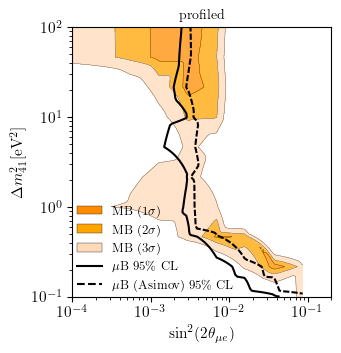

In [23]:
fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax1.set_title(fr"profiled", fontsize=10)
ax1.set_xlim(1e-4,0.2)

le = 100 # len(np.unique(prof_x))
kwargs_interp = {'fine_gridx': le,  
                'fine_gridy': le, 
                'logx':True, 
                'logy':True,
                }

X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MiniApp_deltachi2, **kwargs_interp)
cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2, **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

# ax1.scatter(prof_x, prof_y, c=np.log10(prof_MiniApp_deltachi2),  s=10)

ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')


ax1.legend(loc=(0,0), fontsize=9)
# fig.savefig(f"{micro.path_plots}/MH_full_osc_sin2thetaemuSQR_profiled.pdf", bbox_inches='tight', dpi=300)

### Ue4 vs dm4 (profile over Umu4)

In [9]:
data = np.load(f"fit_data/MH_osc_full_using2009dis.npy", allow_pickle=True)

MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 

MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

Ue4SQR, Umu4SQR, dm4SQR = data[:,2], data[:,3], data[:,1]**2
sin2theta = 4*Ue4SQR*Umu4SQR

In [10]:
# Profile each chi2
prof_x, prof_y, prof_MiniApp_deltachi2 = profile_in_plane(Ue4SQR, dm4SQR, MiniApp_deltachi2)
prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2 = profile_in_plane(Ue4SQR, dm4SQR, MicroApp_deltachi2)
prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2 = profile_in_plane(Ue4SQR, dm4SQR, MicroApp_Asimov_deltachi2)

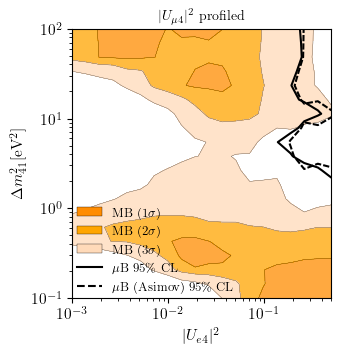

In [11]:
fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r"$|U_{e 4}|^2$", fontproperties=pt.font)
ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax1.set_title(fr"$|U_{{\mu 4}}|^2$ profiled", fontsize=10)

le = len(np.unique(Ue4SQR))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MiniApp_deltachi2, **kwargs_interp)
cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2, **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax1.legend(loc=(0,0), fontsize=9)
# fig.savefig(f"{micro.path_plots}/MH_full_osc_ue4_profiled.pdf", bbox_inches='tight', dpi=300)

### Umu4 vs dm4 (profile over Ue4)

In [12]:
# Profile each chi2
prof_x, prof_y, prof_MiniApp_deltachi2 = profile_in_plane(Umu4SQR, dm4SQR, MiniApp_deltachi2)
prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2 = profile_in_plane(Umu4SQR, dm4SQR, MicroApp_deltachi2)
prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2 = profile_in_plane(Umu4SQR, dm4SQR, MicroApp_Asimov_deltachi2)

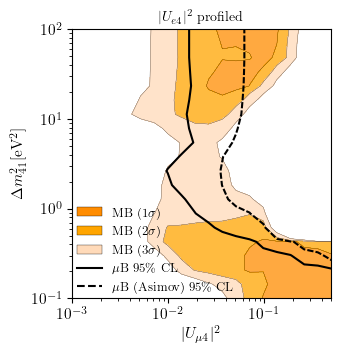

In [13]:
fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2
ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.axis([xmin, xmax, ymin, ymax])
# ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
# ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax1.set_title(fr"$|U_{{e 4}}|^2$ profiled", fontsize=10)

le = len(np.unique(Ue4SQR))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MiniApp_deltachi2, **kwargs_interp)
cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2, **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax1.legend(loc=(0,0), fontsize=9)
# fig.savefig(f"{micro.path_plots}/MH_full_osc_umu4_profiled.pdf", bbox_inches='tight', dpi=300)

### 3D scan full oscillation (slices)

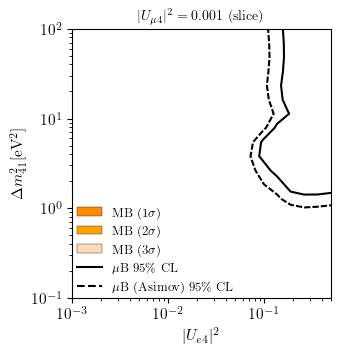

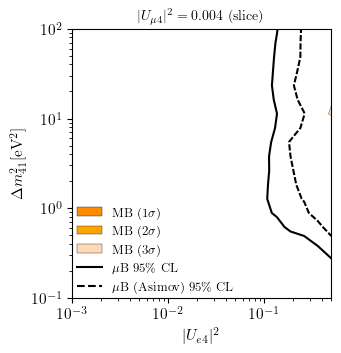

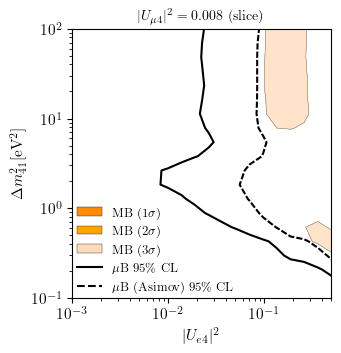

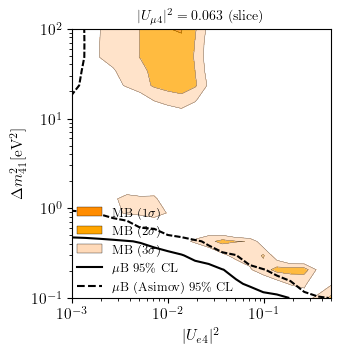

In [14]:
umu4sqr_slices = [0.001, 0.005, 0.01, 0.05]
for umu4sqr_slice in umu4sqr_slices:
    umu4sqr_slice_true = Umu4SQR[np.argmin(np.abs(Umu4SQR - umu4sqr_slice))]
    cut = (Umu4SQR == umu4sqr_slice_true)

    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.axis([Ue4SQR[cut].min(), Ue4SQR[cut].max(), 0.1, 100])
    ax1.set_xlabel(r"$|U_{e4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(fr"$|U_{{\mu 4}}|^2 = {umu4sqr_slice_true:.3f}$ (slice)", fontsize=10)

    le = len(np.unique(Ue4SQR))
    kwargs_interp = {'fine_gridx': le*2,  
                            'fine_gridy': le*2, 
                            'logx':True, 
                            'logy':True,
                            }

    X, Y, Z = pt.interp_grid(Ue4SQR[cut], dm4SQR[cut], MiniApp_deltachi2[cut], **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

    X, Y, Z = pt.interp_grid(Ue4SQR[cut], dm4SQR[cut], MicroApp_deltachi2[cut], **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(Ue4SQR[cut], dm4SQR[cut], MicroApp_Asimov_deltachi2[cut], **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
    # ax2.scatter(sin2theta, dm4SQR, s=1)

    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

    ax1.legend(loc=(0,0), fontsize=9)
    fig.savefig(f"{micro.path_plots}/MH_full_osc_slice_umu4sqr_{umu4sqr_slice_true:.3f}.pdf", bbox_inches='tight', dpi=300)

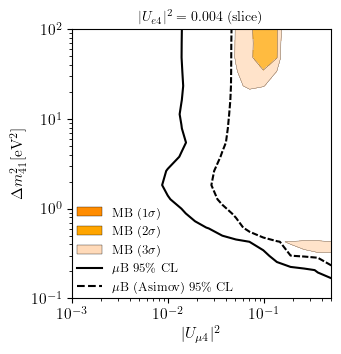

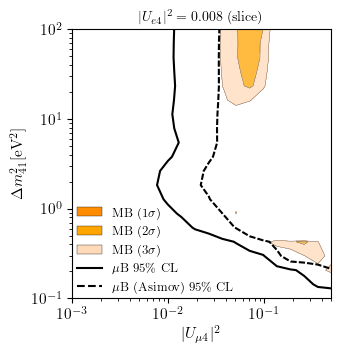

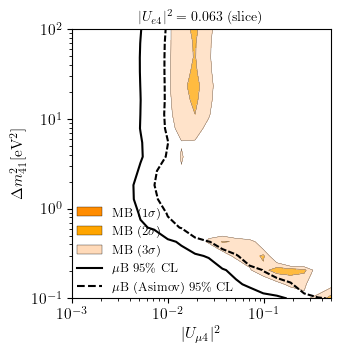

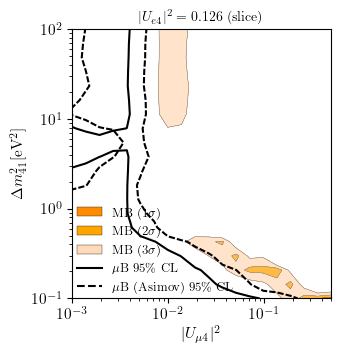

In [15]:
ue4sqr_slices = [0.005, 0.01, 0.05, 0.1]
for ue4sqr_slice in ue4sqr_slices:
    ue4sqr_slice_true = Ue4SQR[np.argmin(np.abs(Ue4SQR - ue4sqr_slice))]
    cut = (Ue4SQR == ue4sqr_slice_true)

    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.axis([Umu4SQR[cut].min(), Umu4SQR[cut].max(), 0.1, 100])
    ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(fr"$|U_{{e 4}}|^2 = {ue4sqr_slice_true:.3f}$ (slice)", fontsize=10)

    le = len(np.unique(Umu4SQR))
    kwargs_interp = {'fine_gridx': le*2,  
                    'fine_gridy': le*2, 
                    'logx':True, 
                    'logy':True,
                    }

    X, Y, Z = pt.interp_grid(Umu4SQR[cut], dm4SQR[cut], MiniApp_deltachi2[cut], **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

    X, Y, Z = pt.interp_grid(Umu4SQR[cut], dm4SQR[cut], MicroApp_deltachi2[cut], **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(Umu4SQR[cut], dm4SQR[cut], MicroApp_Asimov_deltachi2[cut], **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
    # ax2.scatter(sin2theta, dm4SQR, s=1)

    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

    ax1.legend(loc=(0,0), fontsize=9)
    fig.savefig(f"{micro.path_plots}/MH_full_osc_slice_ue4sqr_{ue4sqr_slice_true:.3f}.pdf", bbox_inches='tight', dpi=300)